# TD - Représentation d'images
Dans ce TD, nous nous interesons à la représentation d'images par leur [histogramme couleur](https://en.wikipedia.org/wiki/Color_histogram).

In [54]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

En indexation de donnée par le contenu, une problématique courante est la recherche par similarité de documents. Le but de trier l'ensemble des documents d'une base de donnée du plus similaire au moins similaire par rapport à un document requête en utilisant uniquement des informations extraites des documents.

Dans ce TD, nous voulons faire de la recherche par similarité d'images. Comme pour le texte, nous ne pouvons pas utiliser directement l'image. Nous devons dans un premier temps extraire des paramètres (features) des images. Puis nous utilisons une métrique pour mesurer la similarité entre les images. Nous pouvons alors trier les images par rapport à leur similarité avec l'image requête.

## Holidays dataset
Pour nos expériences, nous utilisons la base d'image [Holidays dataset](http://lear.inrialpes.fr/~jegou/data.php). Cette base de 1491 images provenant de photos de vacances. Les autres ont pris en compte de tester la robustesse de diverses attaques: les rotations, les changements de points de vue et d'éclairage, le flou, etc. L'ensemble de données comprend une très grande variété de types de scène (effets naturels, artificiels, d'eau et de feu, etc.). L'ensemble de données  sont regroupé en 500 groupes d'images, chacun représentant une scène ou un objet distinct. La première image de chaque groupe est l'image de requête et l'objectif est de récupérer en premier les autres images du groupe.

<center><img src="./holidays.jpg" width=800px></center>

Le code suivant permet de crée la liste des images de la base :

In [55]:
import glob
import os

images_dir = './Holidays_dataset'

image_file_names = sorted([os.path.split(f)[1] for f in glob.glob(os.path.join(images_dir, '*.jpg'))])

N = len(image_file_names)

Le groupe des images et leurs indices dans le groupe sont codés dans leurs noms. Par exemple l'image `100502.jpg` est la $3^\text{éme}$ image du $6^\text{éme}$ groupe :
- `1`**`005`**`02.jpg` $\Rightarrow 6^\text{éme}$ groupe
- `1005`**`02`**`.jpg` $\Rightarrow 3^\text{éme}$ image du groupe
L'image qui est utilisé comme requête dans chaque groupe est la $1^\text{ére}$ image du groupe (`1005`**`00`**`.jpg`).

Le code suivant permet de récupéré les groupes de chaque image et les images requêtes:

In [56]:
y = np.asarray([int(f[1:4]) for f in image_file_names]) # verite terrain: recupere pour chaque imag le num de son groupe (ex:005 au dessus) 
queries = np.asarray([f.endswith('00.jpg') for f in image_file_names]) # vecteur de booléens : VRAI aux indices des images servant de requetes (celles finissant par 000)

- `y` $\in \mathbb{N}^N$ est le vecteur de l'indice de groupe pour chaque image.
- `queries` $\in \{\text{False},\text{True}\}^N$ est le vecteur booléen qui indique si l'image est une requête ou non.

**À faire -** Écrivez le code pour ouvrir toutes les images de la base et stockées les dans la liste `images`.

**Aide -** Regardez l'aide des fonctions : [`scipy.misc.imread`](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.misc.imread.html), [`os.path.join`](https://docs.python.org/3/library/os.path.html#os.path.join) et [les listes en python](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists)

In [57]:
# from scipy.misc import imread
# ou
!pip3 install imageio --user
from imageio import imread

images=[]
for file_name in image_file_names: 
    file_path = os.path.join(images_dir, file_name)
    images.append(imread(file_path,mode='RGB'))




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\ilyas\AppData\Local\Temp\ipykernel_31524\2985797419.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imread(file_path,mode='RGB'))


**À faire** - À l'aide de la fonction [`matplotlib.pyplot.imshow`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow), visualisez un image de la base.

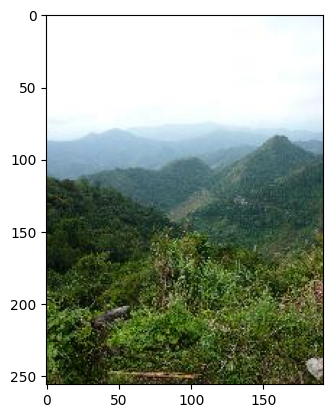

In [58]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

**À faire** - Affichez les dimentions de l'image ([`numpy.ndarray.shape`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html))

In [59]:
images[0].shape



(256, 192, 3)

**Question** - À quoi corresponde ces trois dimensions ?

- la première dimension est la hauteur de l'image
- la deuxième dimension est la largeur de l'image
- la troisième dimension est les codage RGB des couleurs de l'image

## Histogramme couleur

Pour représenté les images, nous utilisons l'histogramme de la proportion des couleurs dans l'image. 

Le codage [RGB](https://en.wikipedia.org/wiki/RGB_color_model) (Red, Green, Blue) sur 24 bits (3 canaux de 8 bits) permet de coder : 16777216 couleurs differentes.

**Question -** Est il judicieux d'utiliser toutes les couleurs pour calculer l'histogramme couleur des images ?

Non car nous obtiendrons un vecteur de 16777216 dimensions pour représenter chaque image, c'est beaucoup trop grand.

### Réduction du nombre de couleur
Nous voulons alors réduire le nombre de couleur utilisé. Pour cela, il est judicieux de rechercher les $P$ couleurs les plus couramment utilisées dans nos images et ensuite de remplacer pour chaque pixel de chaque image la couleur du pixel par la couleur la plus proche parmi les $P$ couleurs les plus courantes. Cette méthode s'appelle la [quantification couleur](https://en.wikipedia.org/wiki/Color_quantization) et elle est basé sur l'utilisation d'algorithme de [clustering](https://en.wikipedia.org/wiki/Cluster_analysis).

Pour trouver les couleurs les plus couramment utilisées, nous devons extraire des images l'ensemble des pixels de toute les images et les rassembler dans une matrice.

**À faire -** Ecrivez le code pour extraire tous les pixels de toutes les images stockées dans la matrice `rgb_samples` de dimension $\text{nombre total de pixel}\times 3$

**Aide -** Regardez l'aide des fonctions : [`numpy.reshape`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) (lire attentivement la description du paramètre `newshape`) et [`numpy.vstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html)

In [60]:
rgb_samples = [I.reshape(-1,3) for I in images]
rgb_samples = np.vstack(rgb_samples)

rgb_samples.shape

(72955136, 3)

Nous obtenons un échantillon de plus de 72 millions de couleurs RGB, c'est beaucoup trop. Nous allons en choisir aléatoirement un petit nombre.

**À faire -** Ecrivez le code pour choisir aléatoirement 100000 exemples de couleurs RGB dans la matrice `rgb_samples` et stockez les à nouveau dans la matrice `rgb_samples`.

**Aide -** Regardez l'aide de la fonction : [`numpy.random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) (lire attentivement la description du paramètre `replace`)

In [61]:
s = np.random.choice(rgb_samples.shape[0], 100000, replace=False)
rgb_samples = rgb_samples[s, :]

In [62]:
s.sort()
s

array([    2336,     2484,     2493, ..., 72951242, 72951339, 72953085],
      shape=(100000,), dtype=int32)

Pour déterminer les $P$ couleur les plus courantes, nous allons utiliser l'algorithme [K-Means](https://en.wikipedia.org/wiki/K-means_clustering).

**À faire -** Ecrivez le code pour effectuer un clustering de 128 clusters ($P=128$) avec algorithme K-Means sur notre échantillon de couleur RGB `rgb_samples`.

**Aide -** Regardez l'aide de la fonction : [`sklearn.cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

**Conseil -** Fixez le paramète `n_init` à 1.

In [63]:
from sklearn.cluster import KMeans
P=256
kms = KMeans(P,n_init=10,verbose=0)
kms.fit(rgb_samples)



,n_clusters,256
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


La fonction suivant permet de réorganiser les couleurs  obtenue par le clustering dans l'ordre des teintes du codage couleur [HSV](https://fr.wikipedia.org/wiki/Teinte_Saturation_Valeur)

In [64]:
import colorsys
def reorganize_clusters(kms):
    h = np.zeros((kms.n_clusters, ))
    for i in range(kms.n_clusters):
        r,g,b = kms.cluster_centers_[i,:]/255.0
        h[i] = colorsys.rgb_to_hsv(r, g, b)[0]
    idx = np.argsort(h)
    kms.cluster_centers_ = kms.cluster_centers_[idx,:]

Nous l'appliquons sur notre objet KMeans

In [65]:
reorganize_clusters(kms)

**À faire -** Ecrivez le code pour afficher l'image de la palette couleur obtenu avec le clustering (par exemple, une image de 8 ligne par ? pixels).

**Aide -** Regardez l'aide des fonctions : [`numpy.reshape`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) et [`matplotlib.pyplot.imshow`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow)

**Conseil -** Ajoutez le paramètre : `interpolation='nearest'` pour la fonction `imshow`.

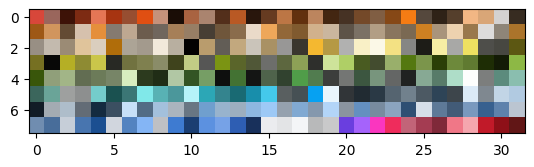

In [66]:
palette = kms.cluster_centers_.astype(np.uint8)
plt.imshow(palette.reshape((8,-1,3)), interpolation='nearest')

Nous voulons voir l'effet de la quantification couleur sur une image.

**À faire -** Choisissez aléatoirement une des images et écrivez le code pour obtenir sa version quantifiée. Puis affichez les deux images pour les comparer.

**Aide -** Regardez l'aide des fonctions : [`sklearn.cluster.KMeans.predict`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict), [`numpy.reshape`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) et [`matplotlib.pyplot.imshow`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow)

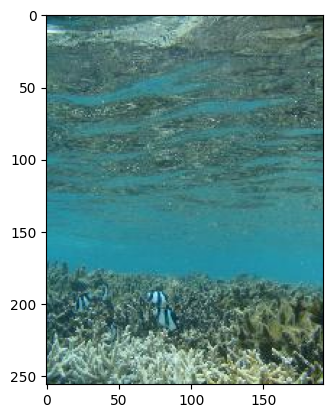

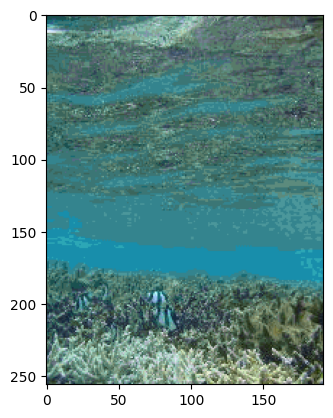

In [67]:
I = images[100]

I_couleur_index = kms.predict(I.astype(np.float64).reshape((-1,3)))
I_quantifier = palette[I_couleur_index,:].reshape((I.shape[0],I.shape[1],3))

plt.figure()
plt.imshow(I)
plt.figure()
plt.imshow(I_quantifier)

Nous maintenant calculer, histogramme couleur d'un image avec les couleurs obtenu apres quantification.

**À faire -** Completez la fonction `def compute_hist(kmeans, I)` qui retourne un vecteur contenant la proportion de chaque couleur dans dans l'image `I`.

**Aide -** Regardez l'aide des fonctions : [`sklearn.cluster.KMeans.predict`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict), [`numpy.reshape`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) et [`numpy.unique`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) (lire attentivement la description du paramètre `return_counts`).

In [68]:
def compute_hist(kmeans, I):
    x = np.zeros((kmeans.n_clusters, ))
    idx = kmeans.predict(I.astype(np.float64).reshape((-1,3)))
    idv, v = np.unique(idx, return_counts=True)
    x[idv] = v
    return x/np.sum(x).astype(np.float32)

Nous voulons visualier l'histogramme couleur une image

**À faire -** Choisissez aléatoirement une des images, utilisez la fonction `def compute_hist(kmeans, I)` pour calculer son histogramme couleur et affichez le.

**Aide -** Regardez l'aide de la fonction : [`matplotlib.pyplot.bar`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar)


**Conseil -** Ajoutez les paramètres : `width = 1`, `color=palette/255.0` et `edgecolor = 'none'` pour la fonction `bar`.

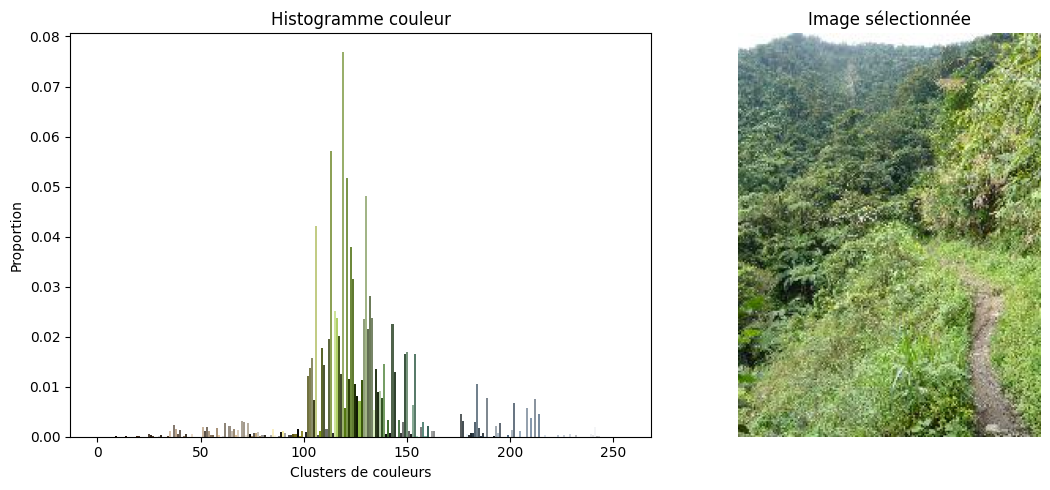

In [69]:
from random import randint

# Sélection aléatoire d'une image
im = images[randint(0,510)]
hist = compute_hist(kms, im)

# Création de deux sous-graphiques côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Affichage de l'histogramme couleur
ax1.bar(np.arange(kms.n_clusters), hist, width=1, color=palette/255, edgecolor='none')
ax1.set_title('Histogramme couleur')
ax1.set_xlabel('Clusters de couleurs')
ax1.set_ylabel('Proportion')

# Affichage de l'image
ax2.imshow(im)
ax2.set_title('Image sélectionnée')
ax2.axis('off')  # Supprime les axes pour l'image

plt.tight_layout()
plt.show()



**À faire -** Ecrivez le code pour calculer l'histogramme couleur de toutes les images et stockez les dans la matrice `X`.

In [70]:
X = np.zeros((len(images), kms.n_clusters), dtype=np.float32)
for i in range(len(images)):
    X[i,:] = compute_hist(kms, images[i])
    

    

## Recherche par similarité

**À faire -** Ecrivez le code pour calculer la distance Euclidienne entre les images requetes et toutes les images, stockez les resultats dans la matrice `dist`.

**Aide -** Regardez l'aide de la fonction : [`sklearn.metrics.pairwise.euclidean_distances`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html)

In [71]:
from sklearn.metrics.pairwise import euclidean_distances
from numpy import sqrt
dist = euclidean_distances(sqrt(X[queries,:]), sqrt(X))

**À faire -** Ecrivez le code pour afficher la matrice des distance `dist`.

**Aide -** Regardez l'aide de la fonction : [`matplotlib.pyplot.matshow`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.matshow)

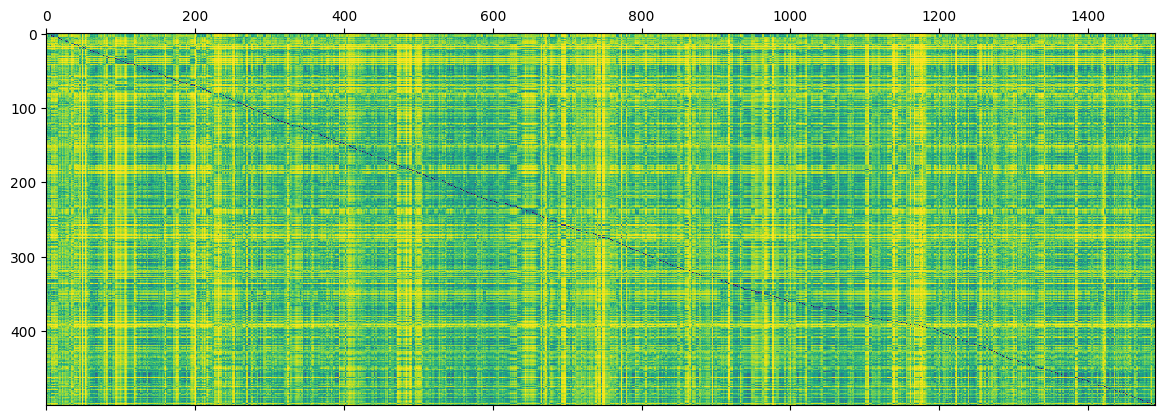

In [72]:
plt.matshow(dist)

**À faire -** Choisissez une requete et ecrivez le code pour afficher les 15 images les plus similaire a la requete.

**Aide -** Regardez l'aide des fonctions : [`numpy.argsort`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html), [`matplotlib.pyplot.imshow`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) et [`matplotlib.pyplot.subplot`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot)

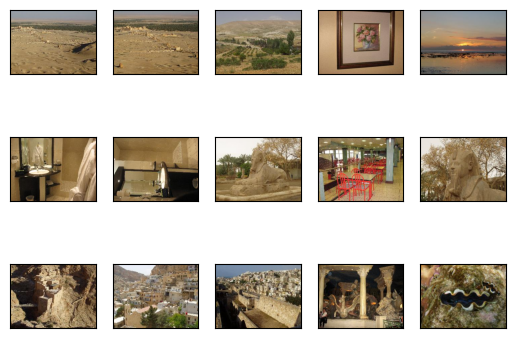

In [73]:
query = 153
# on trie les distances obtenues par ordre croissant
idxsortdist = np.argsort(dist[query,:])
f, axarr = plt.subplots(3, 5) # 3 lignes, 5 colonnes
for i in range(3):
    for j in range(5):
        index = j+i*5
        I = images[idxsortdist[index]]
        axarr[i, j].imshow(I)
        axarr[i, j].axes.get_xaxis().set_visible(False)
        axarr[i, j].axes.get_yaxis().set_visible(False)

f.subplots_adjust(hspace=0.1)

Pour evaluer la performance de notre representation et de la metrique que nous utilisons pour calculer la distance entre les images, nous utilisons la mesure de performence officiler de la base Holidays le mAP ([mean Average Precision](https://en.wikipedia.org/wiki/Information_retrieval#Mean_average_precision)).

La fonction `def score_map(dist, y, queries)` retourne le mAP pour la matrice de distance `dist`.

In [74]:
def score_ap_from_ranks_1 (ranks, nres):
    ap=0.0
    recall_step=1.0/nres
    for ntp,rank in enumerate(ranks):
        if rank==0: 
            precision_0=1.0
        else:
            precision_0=ntp/float(rank)
        precision_1=(ntp+1)/float(rank+1)
        ap+=(precision_1+precision_0)*recall_step/2.0
    return ap

def score_map(dist, y, queries):
    queries_label = -1*np.ones(queries.shape)
    queries_label[queries] = y[queries]
    
    idxsortdist = np.argsort(dist, axis=1)
    
    mAP = 0.0;

    for r in y[queries]:
        y_r = y[idxsortdist[r,:]]
        queries_label_r = queries_label[idxsortdist[r,:]]
        
        nres = np.sum(np.logical_and(y == r, queries_label != r))
        
        tp_ranks = np.sort(np.where(y_r[queries_label_r != r] == r)[0])
        
        ap = score_ap_from_ranks_1 (tp_ranks, nres)

        mAP += ap
    return mAP/ np.sum(queries) * 100.0

**À faire -** Ecrivez le code pour calculer la performence de notre representation avec la distance euclidienne.

In [75]:
score_map(dist, y, queries)

np.float64(51.52668047632473)

Nous pouvons nous comparer aux performances de l'état de l'art sur le [site de la base Holidays](http://lear.inrialpes.fr/~jegou/holidays_state_of_art.html) (section : Global descriptors)